In [1]:
import numpy as np
import math
import routinglibM2 as rl 
import topologyM2 as tp
import matplotlib.pyplot as plt

rng = np.random.default_rng()

def BellmanFordPath(E, P, Ns, t, CostFunc):
    E = [(a,b,CostFunc(P, Ns, a, b, t)) for (a,b) in E]
    n = len(Ns)
    dist = np.zeros(n) + float('inf')
    dist[0] = 0
    p = np.zeros(n, dtype=int) - 1
    
    for i in range(n-1):
        modified = False
        for (a,b,cost) in E:
            if dist[a] < float('inf'):
                if dist[b] > dist[a] + cost:
                    dist[b] = dist[a] + cost
                    p[b] = a
                    modified = True
        if modified == False:
            break
            
    best_path = [n-1]
    while(True):
        i = p[best_path[0]]
        best_path.insert(0, i)
        if i == 0:
            break
            
    return best_path

def UpdatePs(acc_Ps, Ns):
    if np.all(Ns):
        return acc_Ps/Ns
    
    Ps = np.zeros(acc_Ps.shape)
    for i in range(Ps.shape[0]):
        for j in range(Ps.shape[1]):
            Ps[i,j] = acc_Ps[i,j]/Ns[i,j] if Ns[i,j] else 0
    return Ps

def EdgeToNodeUsage(Ns):
    Usage = np.zeros(Ns.shape[0])
    
    for i in range(Ns.shape[0]):
        for j in range(Ns.shape[1]):
            Usage[i] += Ns[i,j]
            Usage[j] += Ns[i,j]
            
    return Usage

def b_ij3(Ps, Ns, a, b, t):
    if Ns[a] == 0 or Ns[b] == 0:
        return 0
    i = Ps[a] - (1.5 * math.log(t)/Ns[a])**0.5
    j = Ps[b] - (1.5 * math.log(t)/Ns[b])**0.5
    return min(1,max(i*j,0))

def CombLCB(T,P,E, Path_list):
    n = A.shape[0]
    Ps = np.zeros(n)
    Ns = np.zeros(n)
    acc_Ps = np.zeros(n)
    acc_cost = np.zeros(T)
    
    path_usage = np.zeros(len(Path_list))
    
    for t in range(T):
        best_path = BellmanFordPath(E, Ps, Ns, t, b_ij3)
        (Ps_samples, Ns_samples, path_cost) = rl.UsePathCombLCB(P,best_path)
        acc_Ps += Ps_samples
        Ns += Ns_samples
        
        Ps = acc_Ps/Ns if np.all(Ns) else np.asarray([acc_Ps[i]/Ns[i] if Ns[i] else 0 for i in range(n)])
        acc_cost[t] = acc_cost[t-1] + path_cost if t > 0 else path_cost
        
        r = rl.RankPath(Path_list, best_path)
        path_usage[r] += 1
        
    return acc_cost, Ns, path_usage

def ESCB_best_path(E, Ps, Ns, t, paths):
    n = len(Ps)
    inner = np.zeros((n,n))
    for (a,b) in E:
        if Ns[a] != 0 and Ns[b] != 0:
            inner[b,a] = ((1.5 * math.log(t)) / Ns[a])*((1.5*math.log(t))/Ns[b])

    inner = inner.reshape((n*n,1))
            
    Ps = Ps.reshape(n,1)
    PsPs = (Ps@Ps.T).reshape((n*n,1))
    wsum = paths@PsPs

    m = paths.shape[0]
    indexes = np.zeros(m)
    for i in range(m):
        indexes[i] = wsum[i] - (paths[i]@inner)**0.5

    best_index = np.argmin(indexes)
    best_path = paths[best_index]
    return best_path

def ESCB2(T,P,E,Path_list):
    n = P.shape[0]
    paths = rl.PathListAsMatrix(Path_list,n)
    Ps = np.zeros(n)
    Ns = np.zeros(n)
    acc_Ps = np.zeros(n)
    acc_cost = np.zeros(T)
    path_usage = np.zeros(len(Path_list))
    
    for t in range(T):
        best_path = ESCB_best_path(E,Ps,Ns,t,paths)
        (Ps_samples, Ns_samples, path_cost) = rl.UsePathESCB(P,best_path)
        acc_Ps += Ps_samples
        Ps = acc_Ps/Ns if np.all(Ns) else np.asarray([acc_Ps[i]/Ns[i] if Ns[i] else 0 for i in range(n)])
        Ns += Ns_samples
        acc_cost[t] = acc_cost[t-1] + path_cost if t > 0 else path_cost
        
        best_path = rl.PathToList(best_path)
        r = rl.RankPath(Path_list, best_path)
        path_usage[r] += 1
        
    return (acc_cost, Ns, path_usage)
        
def TSCost(Ps, _, a, b, __):
    x = rng.beta(Ps[a,0]+1, Ps[a,1]+1)
    y = rng.beta(Ps[b,0]+1, Ps[b,1]+1)
    return x*y

def CombTS(T,P,E, Path_list):
    n = A.shape[0]
    Ps = np.zeros((n,2)) #col 0: S, col 1: F
    Ns = np.zeros(n)
    acc_cost = np.zeros(T)
    path_usage = np.zeros(len(Path_list))
    
    for t in range(T):
        best_path = BellmanFordPath(E, Ps, Ns, _, TSCost)
        (Ps_samples, Ns_samples, path_cost) = rl.UsePathTS(P,best_path)
        Ps += Ps_samples
        Ns += Ns_samples
        acc_cost[t] = acc_cost[t-1] + path_cost if t > 0 else path_cost
    
        r = rl.RankPath(Path_list, best_path)
        path_usage[r] += 1

    return acc_cost, Ns, path_usage

In [2]:
#T: Learning rounds
#P: Vector of costs C_i
#E: List of node pairs
#Path_list: List of tuples ([path],cost)
#Dest: Destination node index
def RunLearning(Algorithm, Repeats, T, P, E, Dest, Path_list):
  #Find best path
  n = len(P)
  Ns = np.zeros((Repeats, n))
  cost = np.zeros((Repeats, T))  
  path_usage = np.zeros(len(Path_list))
  best_path, min_cost = rl.GetBestPath(E,P,Dest)
  min_costs = (np.arange(T)+1)*min_cost

  p = (np.arange(10)+1) * 0.1
  for r in range(Repeats):
    r_cost, r_node_usage, r_path_usage = Algorithm(T, P, E, Path_list)
    Ns[r] = r_node_usage
    cost[r] = r_cost   
    path_usage += r_path_usage
    t = Repeats/10
    if round(r/Repeats,2) in p:
      print(f'{100 * round(r/Repeats,2)}% done')
    
  regret = cost - min_costs
  regret_mean = np.mean(regret, axis=0)
  regret_std = np.std(regret, axis=0)
  path_usage = path_usage/Repeats
  return (regret_mean, regret_std, Ns, path_usage)

10.0% done
20.0% done
40.0% done
50.0% done
80.0% done
90.0% done
CombLCB did not use 312 paths in any experiment
10.0% done
20.0% done
40.0% done
50.0% done
80.0% done
90.0% done
CombTS did not use 350 paths in any experiment
10.0% done
20.0% done
40.0% done
50.0% done
80.0% done
90.0% done
ESCB2 did not use 351 paths in any experiment


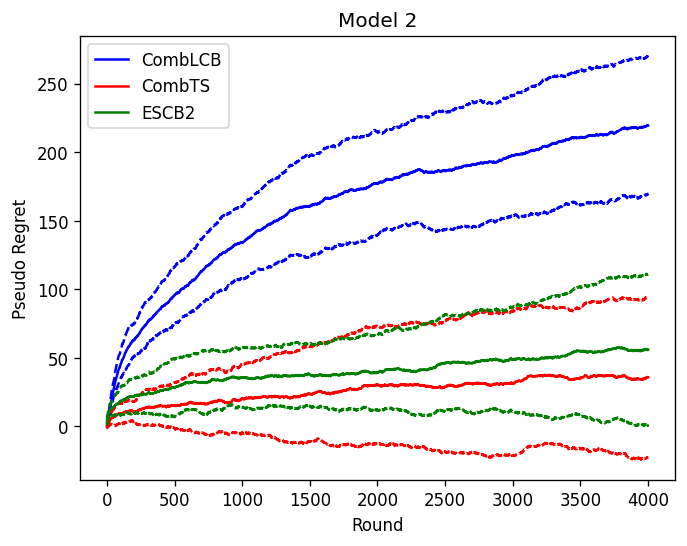

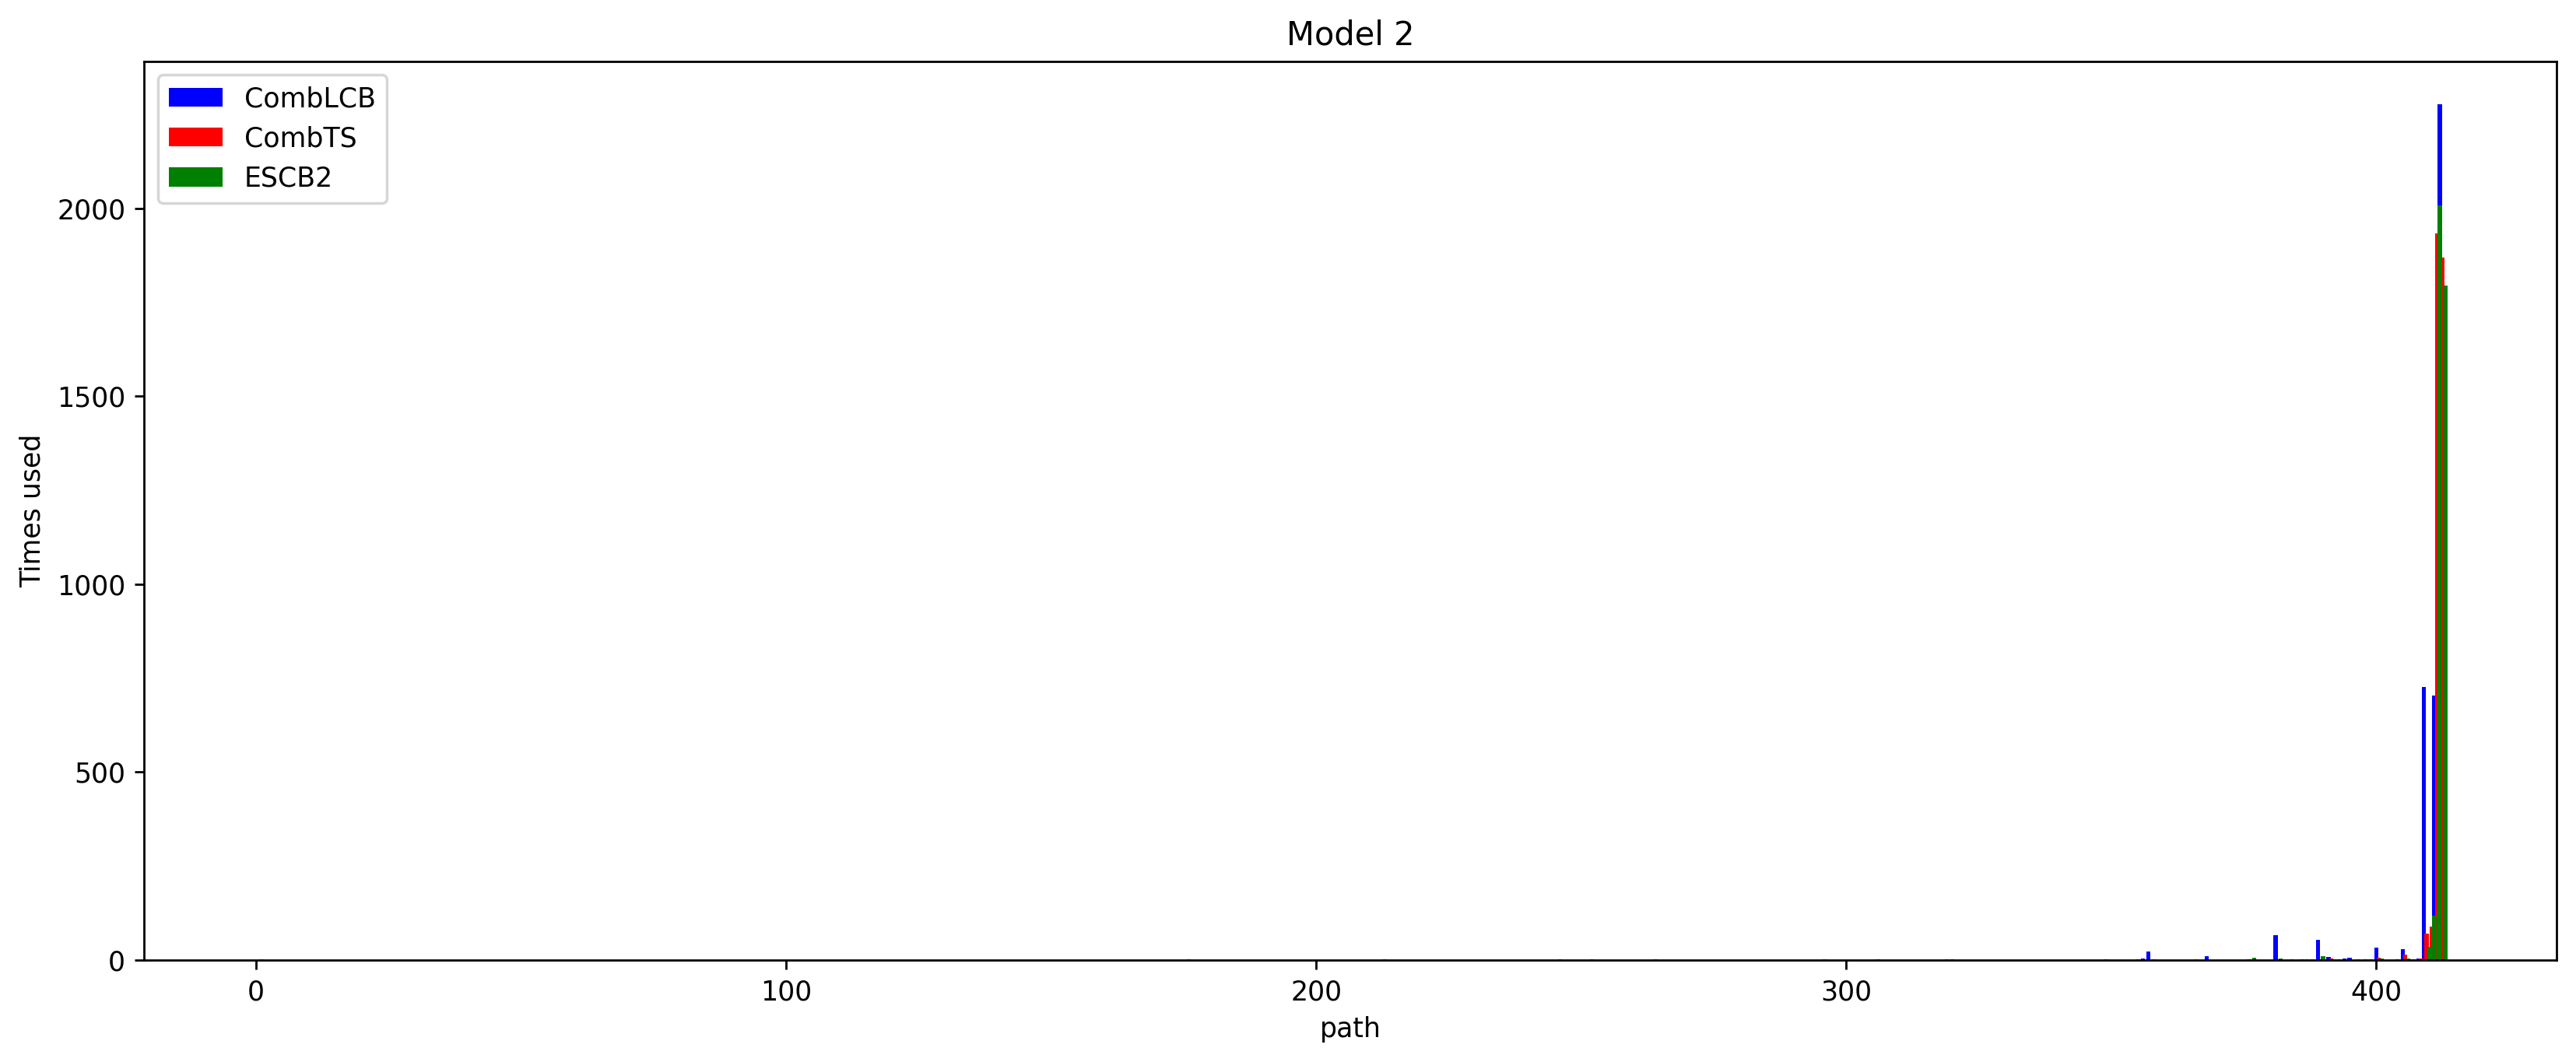

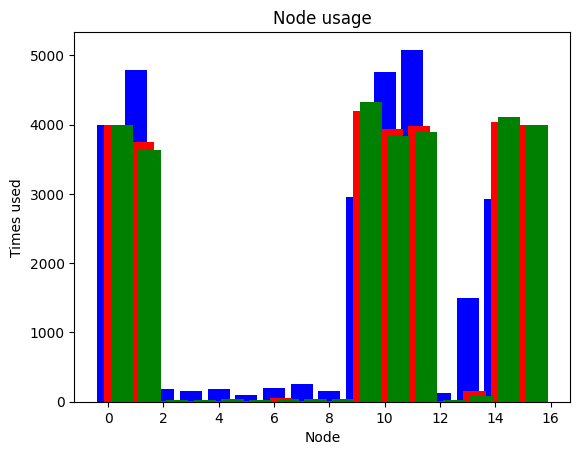

In [3]:
#Initialize learning setup
T = 4000
Repeats = 40
A = tp.GetNetwork()
P = tp.GetP()
E = rl.GetEdges(A)
Source = tp.Source()
Dest = tp.Destination()
Path_list = rl.ListPaths(A,P,Source,Dest)
Algorithms = [CombLCB, CombTS, ESCB2]
AlgorithmLabels = ['CombLCB', 'CombTS', 'ESCB2']
colors = ['blue', 'red', 'green']

plt.figure(1, dpi=120)
plt.figure(2, figsize=(16,6), dpi=250)
plt.figure(2, figsize=(16,6), dpi=250)

for i in range(len(Algorithms)):
    Regret, Regret_std, Ns, path_usage = RunLearning( Algorithms[i],Repeats, 
                                          T,P,E, Dest, Path_list)
    
    not_used = 0
    for index in path_usage:
        if index == 0:
            not_used += 1
    
    print(f'{AlgorithmLabels[i]} did not use {not_used} paths in any experiment')
    
    plt.figure(1)
    plt.title('Pseudo regret')
    x = np.arange(T) + 1
    plt.plot(x,Regret, color=colors[i], label=AlgorithmLabels[i])
    plt.plot(x,Regret-Regret_std, '--', color=colors[i])
    plt.plot(x,Regret+Regret_std, '--', color=colors[i])

    plt.figure(2)
    plt.title('Path usage')
    x2 = np.arange(len(path_usage))
    plt.bar(x2+i/2, path_usage, color=colors[i], label=AlgorithmLabels[i])
    
    plt.figure(3)
    plt.title('Node usage')
    Ns = np.mean(Ns, axis=0)
    x3 = np.arange(len(Ns))
    plt.bar(x3+i/4,Ns, color=colors[i], label=AlgorithmLabels[i])

    
    
    
plt.figure(1)
plt.title('Model 2')
plt.xlabel('Round')
plt.ylabel('Pseudo Regret')
plt.legend(loc='upper left')
plt.figure(2)
plt.title('Model 2')
plt.xlabel('path')
plt.ylabel('Times used')
plt.legend(loc='upper left')
plt.figure(3)
plt.title('Node usage')
plt.xlabel('Node')
plt.ylabel('Times used')
plt.show()